In [5]:
import dask.dataframe as dd

# Указываем путь к файлу
file_path = "./Files_about_flights/BoardingData.csv"

# Чтение данных в dask dataframe
df = dd.read_csv(file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Показать первые несколько строк
df.head()


,PassengerFirstName,PassengerSecondName,PassengerLastName,PassengerSex,PassengerBirthDate,PassengerDocument,BookingCode,TicketNumber,Baggage,FlightDate,FlightTime,FlightNumber,CodeShare,Destination
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow


In [9]:
import dask.dataframe as dd
import pandas as pd
import json

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"

# Шаг 1: Чтение данных из CSV-файла
df_boarding = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_boarding = df_boarding.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Шаг 3: Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

# Собираем данные по полям, которые хотим объединить с boarding данными
parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    for flight in profile["Registered Flights"]:
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"],
            "DepartureCity": flight["Departure"]["City"],
            "DepartureAirport": flight["Departure"]["Airport"]
        })

# Преобразование списка в pandas DataFrame
df_profiles = pd.DataFrame(parsed_data)

# Преобразуем pandas DataFrame в dask DataFrame
df_profiles = dd.from_pandas(df_profiles, npartitions=1)

# Шаг 4: Объединение данных по столбцам
df_merged = dd.merge(df_boarding, df_profiles, on=['First Name', 'Last Name', 'Sex', 'Document', 'Flight Number', 'Share Code', 'Flight Date', 'ArrivalCity'], how='left')

# Выводим первые несколько строк объединенного DataFrame
df_merged.head()


,First Name,PassengerSecondName,Last Name,Sex,PassengerBirthDate,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,ArrivalAirport,DepartureCity,DepartureAirport
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,NaN,NaN,NaN
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,NaN,NaN,NaN


In [13]:
output_file_path = "./Files_about_flights/results.csv"
df_merged.compute().to_csv(output_file_path, index=False)  # Сохраняем результат в CSV
# Альтернативный вариант: Сохранение в Parquet-файл
# output_parquet_file = "./Files_about_flights/results.parquet"
# df_merged.to_parquet(output_parquet_file)

In [15]:
import dask.dataframe as dd
import pandas as pd
import json

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
output_file_path = "./Files_about_flights/results.csv"  # Сохраняем в CSV

# Шаг 1: Чтение данных из CSV-файла
df_boarding = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_boarding = df_boarding.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Шаг 3: Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

# Собираем данные по полям, которые хотим объединить с boarding данными
parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"],
            "DepartureCity": flight["Departure"]["City"],
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None),
            "Loyalty Program": [prog.get("Status") for prog in profile.get("Loyality Programm", [])],
        })

# Преобразование списка в pandas DataFrame
df_profiles = pd.DataFrame(parsed_data)

# Преобразуем pandas DataFrame в dask DataFrame
df_profiles = dd.from_pandas(df_profiles, npartitions=1)

# Шаг 4: Объединение данных по столбцам
df_combined = dd.concat([df_boarding, df_profiles], ignore_index=True)

# Шаг 5: Сохранение объединённого DataFrame в CSV-файл
df_combined.compute().to_csv(output_file_path, index=False)  # Сохраняем результат в CSV

df_combined.head()


,First Name,PassengerSecondName,Last Name,Sex,PassengerBirthDate,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,ArrivalAirport,DepartureCity,DepartureAirport,NickName,Loyalty Program
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,NaN,NaN,NaN,NaN,NaN
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,NaN,NaN,NaN,NaN,NaN


In [21]:
df_combined.head(200000)

,First Name,PassengerSecondName,Last Name,Sex,PassengerBirthDate,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,ArrivalAirport,DepartureCity,DepartureAirport,NickName,Loyalty Program
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,NaN,NaN,NaN,NaN,NaN
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,NaN,NaN,NaN,NaN,NaN
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155142,RAMIL,S.,DOROFEEV,Male,02/14/1994,3256 077151,SNRBXU,8653871661040452,Delayed,2017-05-18,06:30,SU1158,Own,Rostov,NaN,NaN,NaN,NaN,NaN
155143,RUSLAN,KONSTANTINOVICH,CHISTIAKOV,Male,02/14/1975,3497 458395,Not presented,0223584175158947,NaN,2017-05-18,06:30,SU1158,Own,Rostov,NaN,NaN,NaN,NaN,NaN
155144,SOFIA,VALEREVNA,KALMYKOVA,Female,12/17/1972,6618 352713,Not presented,Not presented,Registered,2017-10-02,07:30,SU5614,Own,Petropavlovsk,NaN,NaN,NaN,NaN,NaN
155145,VIACHESLAV,F.,KONONOV,Male,05/20/2000,4567 242088,Not presented,0975693658645383,Registered,2017-09-16,07:00,SU1640,Own,Omsk,NaN,NaN,NaN,NaN,NaN


In [5]:
import dask.dataframe as dd
import pandas as pd
import json

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
output_file_path = "./Files_about_flights/results.csv"  # Сохраняем в CSV

# Шаг 1: Чтение данных из CSV-файла
df_boarding = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_boarding = df_boarding.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerSecondName' : 'Second Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerBirthDate' : 'Birth Date',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Шаг 3: Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

# Собираем данные по полям, которые хотим объединить с boarding данными
parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"], 
            "DepartureCity": flight["Departure"]["City"],   
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None), 
            "Loyalty Program": [prog.get("Status") for prog in profile.get("Loyality Programm", [])],
        })

# Преобразование списка в pandas DataFrame
df_profiles = pd.DataFrame(parsed_data)

# Проверка размера DataFrame из JSON
print(f"Размер DataFrame из JSON: {df_profiles.shape}")

# Преобразуем pandas DataFrame в dask DataFrame
df_profiles = dd.from_pandas(df_profiles, npartitions=1)

# Шаг 4: Объединение данных по столбцам
df_combined = dd.concat([df_boarding, df_profiles], ignore_index=True)

# Проверка размера объединённого DataFrame
print(f"Размер объединённого DataFrame: {df_combined.shape}")

# Шаг 5: Сохранение объединённого DataFrame в CSV-файл
df_combined.compute().to_csv(output_file_path, index=False)  # Сохраняем результат в CSV


Размер DataFrame из JSON: (1308987, 13)
Размер объединённого DataFrame: (<dask_expr.expr.Scalar: expr=(Concat(frames=[RenameFrame(frame=ReadCSV(30ab5fb), columns={'PassengerFirstName': 'First Name', 'PassengerSecondName': 'Second Name', 'PassengerLastName': 'Last Name', 'PassengerSex': 'Sex', 'PassengerBirthDate': 'Birth Date', 'PassengerDocument': 'Document', 'FlightNumber': 'Flight Number', 'CodeShare': 'Share Code', 'FlightDate': 'Flight Date', 'Destination': 'ArrivalCity'}), df], _kwargs={'ignore_index': True})).size() // 19, dtype=int64>, 19)


In [4]:
# Вызываем compute для получения данных
df_combined_result = df_combined.compute() # вот он -мой датафрейм

# Проверяем размер объединённого DataFrame
print(f"Размер объединённого DataFrame (после compute): {df_combined_result.shape}")

# Сохраняем объединённый DataFrame в CSV-файл
df_combined_result.to_csv(output_file_path, index=False)

df_combined_result.head(200000)

Размер объединённого DataFrame (после compute): (1464134, 19)


,First Name,Second Name,Last Name,Sex,Birth Date,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,ArrivalAirport,DepartureCity,DepartureAirport,NickName,Loyalty Program
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,<NA>,<NA>,<NA>,<NA>,<NA>
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,<NA>,<NA>,<NA>,<NA>,<NA>
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,<NA>,<NA>,<NA>,<NA>,<NA>
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,<NA>,<NA>,<NA>,<NA>,<NA>
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44848,RINAT,NaN,SUKHOV,Male,NaN,NaN,NaN,NaN,NaN,2017-02-05,NaN,MU8732,True,Tokyo,HND,Shanghai,SHA,FrequentFlyer3379,['Basic']
44849,RINAT,NaN,SUKHOV,Male,NaN,NaN,NaN,NaN,NaN,2017-03-04,NaN,MU5281,False,Beijing,PEK,Guangzhou,CAN,FrequentFlyer3379,['Basic']
44850,RINAT,NaN,SUKHOV,Male,NaN,NaN,NaN,NaN,NaN,2017-07-03,NaN,MU2491,False,Wenzhou,WNZ,Guangzhou,CAN,FrequentFlyer3379,['Basic']
44851,RINAT,NaN,SUKHOV,Male,NaN,NaN,NaN,NaN,NaN,2017-08-25,NaN,MU5735,False,Guangzhou,CAN,Lijiang,LJG,FrequentFlyer3379,['Basic']


In [5]:
tab_file_path = "./Files_about_flights/Sirena-export-fixed.tab"

# Определение ширины каждого столбца (укажи ширину на основе структуры файла)
colspecs = [
    (0, 60),   # PaxName
    (60, 72),  # PaxBirthDate
    (72, 84),  # DepartDate
    (84, 96),  # DepartTime
    (96, 108),  # ArrivalDate
    (108, 120),  # ArrivalTime
    (120, 126),  # Flight
    (126, 132),  # CodeSh
    (132, 138),  # From
    (138, 144),  # Dest
    (144, 150),  # Code
    (150, 168),  # e-Ticket
    (168, 180), # TravelDoc
    (180, 186),# Seat
    (186, 192),# Meal
    (192, 198),# TrvCls
    (198, 216),# Fare  Baggage
    (216, 240),# PaxAdditionalInfo
    (240, 246),# Unnamed: 17
    (246, 276), # Unnamed: 18
    (276, 336) # AgentInfo
]

# Чтение файла с использованием фиксированной ширины столбцов
df_sirena = pd.read_fwf(tab_file_path, colspecs=colspecs)

# Вывод названий колонок для проверки
print(df_sirena.head())

                           PaxName PaxBirthDate  DepartDate DepartTime  \
0         ОЗЕРОВ ИЛЬДАР ДАНИИЛОВИЧ   1999-05-15  2017-05-30      00:05   
1       КОЛОСОВ САМИР ТАМЕРЛАНОВИЧ          NaN  2017-12-27      02:15   
2  ИГНАТОВА СНЕЖАНА КОНСТАНТИНОВНА          NaN  2017-09-19      06:40   
3         ЖАРОВ ПЛАТОН АЛЬБЕРТОВИЧ   1999-05-02  2017-03-18      22:10   
4      НИКОЛЬСКИЙ НИКОЛАЙ ИГОРЕВИЧ   1990-12-26  2017-03-18      22:10   

  ArrivalDate ArrivalTime  Flight CodeSh From Dest    Code          e-Ticket  \
0  2017-05-30       08:05  SU1306     NO  SVO  OVB  ZBQSPY  7360415302044672   
1  2017-12-27       04:40  SU1323     NO  MMK  SVO  MHPBBX  7398421117936516   
2  2017-09-19       07:45  SU1481     NO  KJA  SVO  REDLVB  5174973140468001   
3  2017-03-19       01:05  SU1180     NO  SVO  VOG  NSJNGQ  5274206497242737   
4  2017-03-19       01:05  SU1180     NO  SVO  VOG  VWNYGF  6247422701565929   

     TravelDoc  Seat  Meal TrvCls Fare  Baggage PaxAdditionalInfo Unnamed:

In [3]:
import dask.dataframe as dd
import pandas as pd
import time
import json

# Засекаем время начала работы
start_time = time.time()

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
tab_file_path = "./Files_about_flights/Sirena-export-fixed.tab"
output_file_path = "./Files_about_flights/results.csv"

# Шаг 1: Чтение данных из CSV-файла
df_boarding = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_boarding = df_boarding.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerSecondName' : 'Second Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerBirthDate' : 'Birth Date',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:

        if profile.get("Loyality Programm"):
            loyality_program = profile["Loyality Programm"][0]
            loy_prgrm_status = loyality_program.get("Status", None)
            loy_prgrm_code = loyality_program.get("programm", None)
            loy_prgrm_number = loyality_program.get("Number", None)
        else:
            loy_prgrm_status = loy_prgrm_code = loy_prgrm_number = None
        
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"], 
            "DepartureCity": flight["Departure"]["City"],   
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None), 
            "LoyPrgrmStatus": loy_prgrm_status,
            "LoyPrgrmCode": loy_prgrm_code,
            "LoyPrgrmNumber": loy_prgrm_number
        })

# Преобразование списка в pandas DataFrame
df_profiles = pd.DataFrame(parsed_data)

# Преобразуем pandas DataFrame в dask DataFrame
df_profiles = dd.from_pandas(df_profiles, npartitions=1)

# Шаг 3: Чтение файла Sirena-export-fixed.tab
colspecs = [
    (0, 60),   # PaxName
    (60, 72),  # PaxBirthDate
    (72, 84),  # DepartDate
    (84, 96),  # DepartTime
    (96, 108),  # ArrivalDate
    (108, 120),  # ArrivalTime
    (120, 126),  # Flight
    (126, 132),  # CodeSh
    (132, 138),  # From
    (138, 144),  # Dest
    (144, 150),  # Code
    (150, 168),  # e-Ticket
    (168, 180), # TravelDoc
    (180, 186),# Seat
    (186, 192),# Meal
    (192, 198),# TrvCls
    (198, 216),# Fare  Baggage
    (216, 240),# PaxAdditionalInfo
    (240, 246),# Unnamed: 18
    (246, 276), # Unnamed: 19
    (276, 336) # AgentInfo
]

df_sirena = pd.read_fwf(tab_file_path, colspecs=colspecs, dtype={'Unnamed: 19': 'str', 'Unnamed: 18': 'str'})

# Удаляем 'FF#' в столбце Unnamed: 18, оставляем только программный код (например, 'DT')
df_sirena['Unnamed: 18'] = df_sirena['Unnamed: 18'].str.replace('FF#', '', regex=False)

# Шаг 4: Разделение PaxName на три части (Last Name, First Name, Second Name)
df_sirena[['Last Name', 'First Name', 'Second Name']] = df_sirena['PaxName'].str.split(expand=True, n=2)

# Шаг 5: Переименование и объединение столбцов из Sirena с основным датасетом
df_sirena = df_sirena.rename(columns={
    'PaxBirthDate': 'Birth Date',
    'Flight': 'Flight Number',
    'CodeSh': 'Share Code',
    'From': 'DepartureAirport',
    'Dest': 'ArrivalAirport',
    'Code': 'BookingCode',
    'e-Ticket': 'TicketNumber',
    'TravelDoc': 'Document',
    'Fare  Baggage': 'Baggage',
    'DepartDate': 'Flight Date',
    'DepartTime': 'FlightTime',
    'Unnamed: 19': 'LoyPrgrmNumber',
    'Unnamed: 18': 'LoyPrgrmCode'
})

# Добавление недостающих колонок в df_sirena
missing_columns = ['AgentInfo', 'PaxAdditionalInfo', 'Meal', 'Seat', 'ArrivalDate', 'ArrivalTime', 'TrvCls']
for col in missing_columns:
    df_boarding[col] = 'N/A'

# Шаг 6: Объединение всех данных
df_combined = dd.concat([df_boarding, df_profiles, df_sirena], ignore_index=True)

# Удаляем ненужный столбец PaxName
df_combined = df_combined.drop(columns=["PaxName"], errors='ignore')

# Вывод времени работы программы
end_time = time.time()
execution_time = end_time - start_time
print(f"Время работы программы: {execution_time:.2f} секунд")

Время работы программы: 22.06 секунд


In [5]:
# Сохраняем объединённый DataFrame в CSV-файл
df_combined.compute().to_csv(output_file_path, index=False)

# Проверка размера объединённого DataFrame
df_combined_result = df_combined.compute()
print(f"Размер объединённого DataFrame (после объединения): {df_combined_result.shape}")

# Сбрасываем индексы и создаём новые
df_combined_result = df_combined_result.reset_index(drop=True)

# Устанавливаем параметр для отображения всех колонок
pd.set_option('display.max_columns', None)

df_combined_result.head(1610000)

Размер объединённого DataFrame (после объединения): (1619891, 28)


,First Name,Second Name,Last Name,Sex,Birth Date,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,AgentInfo,PaxAdditionalInfo,Meal,Seat,ArrivalDate,ArrivalTime,TrvCls,ArrivalAirport,DepartureCity,DepartureAirport,NickName,LoyPrgrmStatus,LoyPrgrmCode,LoyPrgrmNumber
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609995,АНАТОЛИЙ,ДМИТРИЕВИЧ,КАРТАШОВ,NaN,<NA>,4289 335033,CWXSCO,9560782934205279,YFLXJF,2017-06-14,00:50,SU1382,NO,NaN,OneTwoTrip,<NA>,<NA>,NaN,2017-06-14,04:50,Y,HMA,<NA>,SVO,<NA>,<NA>,<NA>,<NA>
1609996,ЭДУАРД,САМИРОВИЧ,МАЛЬЦЕВ,NaN,<NA>,0486 309859,GPTJWG,9564846814597107,YSTNLG1PC,2017-10-03,16:30,SU6286,NO,NaN,Kiwi.com,8,<NA>,NaN,2017-10-03,16:05,Y,SVO,<NA>,PKC,<NA>,<NA>,DT,58494564
1609997,ДАРИНА,АЙДАРОВНА,ФОКИНА,NaN,1970-11-07,2107 657387,TUEWTD,8730084139040687,YFLXKF1PC,2017-06-13,10:30,SU5684,NO,NaN,Aerobilet,F,<NA>,NaN,2017-06-13,15:15,Y,PKC,<NA>,KHV,<NA>,<NA>,<NA>,<NA>
1609998,ЭЛЬВИРА,ИГНАТОВНА,МАРКОВА,NaN,<NA>,4799 956342,OVAWIQ,2841936475816452,YFLXKN,2017-06-13,10:30,SU5684,NO,NaN,Tickets.ru,<NA>,<NA>,NaN,2017-06-13,15:15,Y,PKC,<NA>,KHV,<NA>,<NA>,<NA>,<NA>


In [1]:
import dask.dataframe as dd
import pandas as pd
import time
import json
import xml.etree.ElementTree as ET

# Засекаем время начала работы
start_time = time.time()

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
tab_file_path = "./Files_about_flights/Sirena-export-fixed.tab"
xml_file_path = "./Files_about_flights/PointzAggregator-AirlinesData.xml"
output_file_path = "./Files_about_flights/results.csv"

# Шаг 1: Чтение данных из CSV-файла
df_boarding = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_boarding = df_boarding.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerSecondName' : 'Second Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerBirthDate' : 'Birth Date',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:

        if profile.get("Loyality Programm"):
            loyality_program = profile["Loyality Programm"][0]
            loy_prgrm_status = loyality_program.get("Status", None)
            loy_prgrm_code = loyality_program.get("programm", None)
            loy_prgrm_number = loyality_program.get("Number", None)
        else:
            loy_prgrm_status = loy_prgrm_code = loy_prgrm_number = None
        
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"], 
            "DepartureCity": flight["Departure"]["City"],   
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None), 
            "LoyPrgrmStatus": loy_prgrm_status,
            "LoyPrgrmCode": loy_prgrm_code,
            "LoyPrgrmNumber": loy_prgrm_number
        })

# Преобразование списка в pandas DataFrame
df_profiles = pd.DataFrame(parsed_data)

# Преобразуем pandas DataFrame в dask DataFrame
df_profiles = dd.from_pandas(df_profiles, npartitions=1)

# Шаг 3: Чтение файла Sirena-export-fixed.tab
colspecs = [
    (0, 60),   # PaxName
    (60, 72),  # PaxBirthDate
    (72, 84),  # DepartDate
    (84, 96),  # DepartTime
    (96, 108),  # ArrivalDate
    (108, 120),  # ArrivalTime
    (120, 126),  # Flight
    (126, 132),  # CodeSh
    (132, 138),  # From
    (138, 144),  # Dest
    (144, 150),  # Code
    (150, 168),  # e-Ticket
    (168, 180), # TravelDoc
    (180, 186),# Seat
    (186, 192),# Meal
    (192, 198),# TrvCls
    (198, 216),# Fare  Baggage
    (216, 240),# PaxAdditionalInfo
    (240, 246),# Unnamed: 18
    (246, 276), # Unnamed: 19
    (276, 336) # AgentInfo
]

df_sirena = pd.read_fwf(tab_file_path, colspecs=colspecs, dtype={'Unnamed: 19': 'str', 'Unnamed: 18': 'str'})

# Удаляем 'FF#' в столбце Unnamed: 18, оставляем только программный код (например, 'DT')
df_sirena['Unnamed: 18'] = df_sirena['Unnamed: 18'].str.replace('FF#', '', regex=False)

# Шаг 4: Разделение PaxName на три части (Last Name, First Name, Second Name)
df_sirena[['Last Name', 'First Name', 'Second Name']] = df_sirena['PaxName'].str.split(expand=True, n=2)

# Шаг 5: Переименование и объединение столбцов из Sirena с основным датасетом
df_sirena = df_sirena.rename(columns={
    'PaxBirthDate': 'Birth Date',
    'Flight': 'Flight Number',
    'CodeSh': 'Share Code',
    'From': 'DepartureAirport',
    'Dest': 'ArrivalAirport',
    'Code': 'BookingCode',
    'e-Ticket': 'TicketNumber',
    'TravelDoc': 'Document',
    'Fare  Baggage': 'Baggage',
    'DepartDate': 'Flight Date',
    'DepartTime': 'FlightTime',
    'Unnamed: 19': 'LoyPrgrmNumber',
    'Unnamed: 18': 'LoyPrgrmCode'
})

# Добавление недостающих колонок в df_sirena
missing_columns = ['AgentInfo', 'PaxAdditionalInfo', 'Meal', 'Seat', 'ArrivalDate', 'ArrivalTime', 'TrvCls']
for col in missing_columns:
    df_boarding[col] = 'N/A'

# Шаг 6: Чтение и обработка XML-файла
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Создаем список для хранения данных
data = []

# Проходим по каждому пользователю
for user in root.findall('user'):
    uid = user.get('uid')  # ID пользователя
    first_name = user.find('name').get('first')  # Имя пользователя
    last_name = user.find('name').get('last')  # Фамилия пользователя
    
    # Проходим по каждой карточке
    for card in user.findall('cards/card'):
        card_number = card.get('number')  # Номер карты
        bonus_program = card.find('bonusprogramm').text  # Бонусная программа
        
        # Проходим по каждой активности (рейсу)
        for activity in card.findall('activities/activity'):
            flight_code = activity.find('Code').text  # Код рейса
            flight_date = activity.find('Date').text  # Дата рейса
            departure = activity.find('Departure').text  # Место вылета
            arrival = activity.find('Arrival').text  # Место прилета
            fare = activity.find('Fare').text  # Тип тарифа
            
            # Добавляем все данные в список
            data.append({
                'User uid': uid,
                'First Name': first_name,
                'Last Name': last_name,
                'CardNumber': card_number,
                'BonusProgram': bonus_program,
                'Flight Number': flight_code,
                'Flight Date': flight_date,
                'DepartureAirport': departure,
                'ArrivalAirport': arrival
            })

# Преобразуем список в DataFrame
df_xml = pd.DataFrame(data)

# Разделяем CardNumber на два столбца (LoyPrgrmCode и LoyPrgrmNumber)
df_xml[['LoyPrgrmCode', 'LoyPrgrmNumber']] = df_xml['CardNumber'].str.split(expand=True)

# Объединение столбцов
df_combined = dd.concat([df_boarding, df_profiles, df_sirena, df_xml], ignore_index=True)

# Добавляем столбец BonusProgram в объединенный DataFrame, заполняем N/A для строк без данных
#df_combined['BonusProgram'] = df_combined.get('BonusProgram', 'N/A')

# Удаляем ненужный столбец PaxName
df_combined = df_combined.drop(columns=["PaxName", "CardNumber"], errors='ignore')

# Вывод времени работы программы
end_time = time.time()
execution_time = end_time - start_time
print(f"Время работы программы: {execution_time:.2f} секунд")


Время работы программы: 34.58 секунд


In [2]:
# Сохраняем объединённый DataFrame в CSV-файл
df_combined.compute().to_csv(output_file_path, index=False)

# Проверка размера объединённого DataFrame
df_combined_result = df_combined.compute()
print(f"Размер объединённого DataFrame (после объединения): {df_combined_result.shape}")

# Сбрасываем индексы и создаём новые
df_combined_result = df_combined_result.reset_index(drop=True)

# Устанавливаем параметр для отображения всех колонок
pd.set_option('display.max_columns', None)

df_combined_result.head(2055981)

Размер объединённого DataFrame (после объединения): (2055981, 30)


,First Name,Second Name,Last Name,Sex,Birth Date,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,AgentInfo,PaxAdditionalInfo,Meal,Seat,ArrivalDate,ArrivalTime,TrvCls,ArrivalAirport,DepartureCity,DepartureAirport,NickName,LoyPrgrmStatus,LoyPrgrmCode,LoyPrgrmNumber,User uid,BonusProgram
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055976,EMIL,NaN,KAZAKOV,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-01,NaN,SU6402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LED,<NA>,SVX,<NA>,<NA>,DT,269347755,293103570,Delta SkyMiles
2055977,EMIL,NaN,KAZAKOV,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-14,NaN,AR1142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FCO,<NA>,EZE,<NA>,<NA>,SU,856232932,293103570,Aeroflot Bonus
2055978,EMIL,NaN,KAZAKOV,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-16,NaN,AR1143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZE,<NA>,FCO,<NA>,<NA>,SU,856232932,293103570,Aeroflot Bonus
2055979,UL'YANA,NaN,KONONOVA,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-12,NaN,GA502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PNK,<NA>,CGK,<NA>,<NA>,DT,302785701,265781820,Delta SkyMiles


In [4]:
#Здесь я читаю все xlsx и сохраняю их в csv, т.к. читаются они около 22 мин, чтобы потом быстрее их читать 
import pandas as pd
import os
import time

# Засекаем время начала работы
start_time = time.time()

# Путь к распакованной директории
folder_path = './Files_about_flights/YourBoardingPassDotAero'

# Создадим список для хранения всех DataFrame'ов из всех файлов и листов
all_data = []

# Проходим по каждому файлу в директории
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.xlsx'):
            file_path = os.path.join(root, file)

            # Читаем все листы в Excel-файле
            sheets = pd.read_excel(file_path, sheet_name=None, header=None)

            # Проходим по каждому листу
            for sheet_name, data in sheets.items():
                try:
                    # Извлекаем нужные данные из листа
                    name = data.iloc[2, 1]
                    sequence = data.iloc[0, 7]
                    flight_number = data.iloc[4, 0]
                    departure_city = data.iloc[4, 3]
                    arrival_city = data.iloc[4, 7]
                    departure_airport = data.iloc[6, 3]
                    arrival_airport = data.iloc[6, 7]
                    flight_time = data.iloc[8, 2]
                    flight_date = data.iloc[8, 0]
                    seat = data.iloc[10, 7]
                    additional_info = data.iloc[10, 0]
                    pnr = data.iloc[12, 1]

                    # Преобразуем номер билета в строку, чтобы избежать экспоненциальной записи
                    ticket_number = str(data.iloc[12, 4])

                    # Создаем DataFrame для текущего листа
                    df = pd.DataFrame({
                        'Full Name': [name],
                        'SEQUENCE': [sequence],
                        'Flight Number': [flight_number],
                        'DepartureCity': [departure_city],
                        'DepartureAirport': [departure_airport],
                        'ArrivalCity': [arrival_city],
                        'ArrivalAirport': [arrival_airport],
                        'FlightTime': [flight_time],
                        'Flight Date': [flight_date],
                        'Seat': [seat],
                        'PaxAdditionalInfo': [additional_info],
                        'BookingCode': [pnr],
                        'TicketNumber': [ticket_number]
                    })

                    # Добавляем DataFrame в общий список
                    all_data.append(df)

                except Exception as e:
                    print(f"Ошибка при обработке листа {sheet_name} в файле {file}: {e}")

# Объединяем все DataFrame'ы в один большой
final_df = pd.concat(all_data, ignore_index=True)

# Преобразуем колонку 'TicketNumber' в строку (на всякий случай)
final_df['TicketNumber'] = final_df['TicketNumber'].astype(str)

# Сохраняем результат в CSV без кавычек и экспоненциальной записи
final_df.to_csv('xlsx_data.csv', index=False)

# Вывод времени работы программы
end_time = time.time()
execution_time = end_time - start_time
print(f"Время работы программы: {execution_time:.2f} секунд")

# Печатаем результат
final_df.head()

Время работы программы: 1276.02 секунд


,Full Name,SEQUENCE,Flight Number,DepartureCity,DepartureAirport,ArrivalCity,ArrivalAirport,FlightTime,Flight Date,Seat,PaxAdditionalInfo,BookingCode,TicketNumber
0,KOVALEV LEV,68,AZ7942,MILAN,MXP,BIRMINGHAM,BHX,10:25,2017-07-19,NaN,Boarding is ended 20 minutes before departure ...,HLZMLJ,2338449502240501
1,MUKHINA ALIIA,29,DL3698,DETROIT MI,DTW,LANSING MI,LAN,15:40,2017-07-19,NaN,Boarding is ended 20 minutes before departure ...,DHLPHO,9395947742021797
2,VIACHESLAV KHUDIAKOV,52,AR1909,RIO DE JANEIRO,GIG,BUENOS AIRES,EZE,14:10,2017-07-19,NaN,Boarding is ended 20 minutes before departure ...,FUKDMA,6178644805580131
3,GOLOVINA NATASHA,66,OK761,PARIS,CDG,PRAGUE,PRG,15:00,2017-07-19,NaN,Boarding is ended 20 minutes before departure ...,TVCDCU,9571752484882104
4,NIKULIN LEONID,25,DL5996,WASHINGTON,DCA,NEW YORK NY,LGA,16:59,2017-07-19,NaN,Boarding is ended 20 minutes before departure ...,PEJRZH,8158128146132083


In [1]:
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия

import dask.dataframe as dd
import pandas as pd
import time
import json
import xml.etree.ElementTree as ET

# Засекаем время начала работы
start_time = time.time()

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
tab_file_path = "./Files_about_flights/Sirena-export-fixed.tab"
xml_file_path = "./Files_about_flights/PointzAggregator-AirlinesData.xml"
xlsx_data_path = "./xlsx_data.csv"
output_file_path = "./Files_about_flights/results.csv"

# Шаг 1: Чтение данных из CSV-файла
df_csv = dd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_csv = df_csv.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerSecondName' : 'Second Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerBirthDate' : 'Birth Date',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:

        if profile.get("Loyality Programm"):
            loyality_program = profile["Loyality Programm"][0]
            loy_prgrm_status = loyality_program.get("Status", None)
            loy_prgrm_code = loyality_program.get("programm", None)
            loy_prgrm_number = loyality_program.get("Number", None)
        else:
            loy_prgrm_status = loy_prgrm_code = loy_prgrm_number = None
        
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"], 
            "DepartureCity": flight["Departure"]["City"],   
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None), 
            "LoyPrgrmStatus": loy_prgrm_status,
            "LoyPrgrmCode": loy_prgrm_code,
            "LoyPrgrmNumber": loy_prgrm_number
        })

# Преобразование списка в pandas DataFrame
df_json = pd.DataFrame(parsed_data)

# Преобразуем pandas DataFrame в dask DataFrame
df_json = dd.from_pandas(df_json, npartitions=1)

# Шаг 3: Чтение файла Sirena-export-fixed.tab
colspecs = [
    (0, 60),   # PaxName
    (60, 72),  # PaxBirthDate
    (72, 84),  # DepartDate
    (84, 96),  # DepartTime
    (96, 108),  # ArrivalDate
    (108, 120),  # ArrivalTime
    (120, 126),  # Flight
    (126, 132),  # CodeSh
    (132, 138),  # From
    (138, 144),  # Dest
    (144, 150),  # Code
    (150, 168),  # e-Ticket
    (168, 180), # TravelDoc
    (180, 186),# Seat
    (186, 192),# Meal
    (192, 198),# TrvCls
    (198, 216),# Fare  Baggage
    (216, 240),# PaxAdditionalInfo
    (240, 246),# Unnamed: 18
    (246, 276), # Unnamed: 19
    (276, 336) # AgentInfo
]

df_tab = pd.read_fwf(tab_file_path, colspecs=colspecs, dtype={'Unnamed: 19': 'str', 'Unnamed: 18': 'str'})

# Удаляем 'FF#' в столбце Unnamed: 18, оставляем только программный код (например, 'DT')
df_tab['Unnamed: 18'] = df_tab['Unnamed: 18'].str.replace('FF#', '', regex=False)

# Шаг 4: Разделение PaxName на три части (Last Name, First Name, Second Name)
df_tab[['Last Name', 'First Name', 'Second Name']] = df_tab['PaxName'].str.split(expand=True, n=2)

# Шаг 5: Переименование и объединение столбцов из Sirena с основным датасетом
df_tab = df_tab.rename(columns={
    'PaxBirthDate': 'Birth Date',
    'Flight': 'Flight Number',
    'CodeSh': 'Share Code',
    'From': 'DepartureAirport',
    'Dest': 'ArrivalAirport',
    'Code': 'BookingCode',
    'e-Ticket': 'TicketNumber',
    'TravelDoc': 'Document',
    'Fare  Baggage': 'Baggage',
    'DepartDate': 'Flight Date',
    'DepartTime': 'FlightTime',
    'Unnamed: 19': 'LoyPrgrmNumber',
    'Unnamed: 18': 'LoyPrgrmCode'
})

# Добавление недостающих колонок в df_sirena
missing_columns = ['AgentInfo', 'PaxAdditionalInfo', 'Meal', 'Seat', 'ArrivalDate', 'ArrivalTime', 'TrvCls']
for col in missing_columns:
    df_csv[col] = 'N/A'

# Шаг 6: Чтение и обработка XML-файла
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Создаем список для хранения данных
data = []

# Проходим по каждому пользователю
for user in root.findall('user'):
    uid = user.get('uid')  # ID пользователя
    first_name = user.find('name').get('first')  # Имя пользователя
    last_name = user.find('name').get('last')  # Фамилия пользователя
    
    # Проходим по каждой карточке
    for card in user.findall('cards/card'):
        card_number = card.get('number')  # Номер карты
        bonus_program = card.find('bonusprogramm').text  # Бонусная программа
        
        # Проходим по каждой активности (рейсу)
        for activity in card.findall('activities/activity'):
            flight_code = activity.find('Code').text  # Код рейса
            flight_date = activity.find('Date').text  # Дата рейса
            departure = activity.find('Departure').text  # Место вылета
            arrival = activity.find('Arrival').text  # Место прилета
            fare = activity.find('Fare').text  # Тип тарифа
            
            # Добавляем все данные в список
            data.append({
                'User uid': uid,
                'First Name': first_name,
                'Last Name': last_name,
                'CardNumber': card_number,
                'BonusProgram': bonus_program,
                'Flight Number': flight_code,
                'Flight Date': flight_date,
                'DepartureAirport': departure,
                'ArrivalAirport': arrival
            })

# Преобразуем список в DataFrame
df_xml = pd.DataFrame(data)

# Разделяем CardNumber на два столбца (LoyPrgrmCode и LoyPrgrmNumber)
df_xml[['LoyPrgrmCode', 'LoyPrgrmNumber']] = df_xml['CardNumber'].str.split(expand=True)

# Шаг 5: Чтение данных из xlsx_data.csv
df_xlsx = pd.read_csv(xlsx_data_path)

# Шаг 6: Объединение всех DataFrame'ов
df_combined = dd.concat([df_csv, df_json, df_tab, df_xml, df_xlsx], ignore_index=True)

# Удаляем ненужный столбец PaxName
df_combined = df_combined.drop(columns=["PaxName", "CardNumber"], errors='ignore')

# Шаг 7: Сохранение результата в CSV
df_combined.to_csv(output_file_path, single_file=True, index=False)

# Вывод времени работы программы
end_time = time.time()
execution_time = end_time - start_time
print(f"Время работы программы: {execution_time:.2f} секунд")


Время работы программы: 49.12 секунд


In [2]:
# Сохраняем объединённый DataFrame в CSV-файл
df_combined.compute().to_csv(output_file_path, index=False)

# Проверка размера объединённого DataFrame
df_combined_result = df_combined.compute()
print(f"Размер объединённого DataFrame (после объединения): {df_combined_result.shape}")

# Сбрасываем индексы и создаём новые
df_combined_result = df_combined_result.reset_index(drop=True)

# Устанавливаем параметр для отображения всех колонок
pd.set_option('display.max_columns', None)

df_combined_result.head(1055981)


#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия

Размер объединённого DataFrame (после объединения): (2671752, 32)


,First Name,Second Name,Last Name,Sex,Birth Date,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,AgentInfo,PaxAdditionalInfo,Meal,Seat,ArrivalDate,ArrivalTime,TrvCls,ArrivalAirport,DepartureCity,DepartureAirport,NickName,LoyPrgrmStatus,LoyPrgrmCode,LoyPrgrmNumber,User uid,BonusProgram,Full Name,SEQUENCE
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,N/A,N/A,N/A,N/A,N/A,N/A,N/A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055976,<NA>,NaN,<NA>,Male,NaN,NaN,NaN,NaN,NaN,2017-07-02,NaN,OK887,False,Prague,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRG,Saint Petersburg,LED,FrequentFlyer69013,Basic,KE,881442799,<NA>,<NA>,<NA>,NaN
1055977,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,2017-02-08,NaN,DL2421,False,Boston MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOS,New York NY,JFK,FrequentFlyer69014,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1055978,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,2017-09-10,NaN,DL6125,False,Grand Rapids MI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRR,New York NY,LGA,FrequentFlyer69014,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1055979,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,2017-01-23,NaN,AF3596,True,New York NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JFK,Barcelona,BCN,FrequentFlyer69014,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [1]:
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия

import pandas as pd
import time
import json
import xml.etree.ElementTree as ET

# Засекаем время начала работы
start_time = time.time()

# Пути к файлам
csv_file_path = "./Files_about_flights/BoardingData.csv"
json_file_path = "./Files_about_flights/FrequentFlyerForum-Profiles.json"
tab_file_path = "./Files_about_flights/Sirena-export-fixed.tab"
xml_file_path = "./Files_about_flights/PointzAggregator-AirlinesData.xml"
xlsx_data_path = "./xlsx_data.csv"
output_file_path = "./Files_about_flights/results.csv"

# Шаг 1: Чтение данных из CSV-файла
df_csv = pd.read_csv(csv_file_path, sep=';', dtype={'PassengerDocument': 'object'})

# Переименование колонок CSV для унификации с JSON
df_csv = df_csv.rename(columns={
    'PassengerFirstName': 'First Name',
    'PassengerSecondName': 'Second Name',
    'PassengerLastName': 'Last Name',
    'PassengerSex': 'Sex',
    'PassengerBirthDate': 'Birth Date',
    'PassengerDocument': 'Document',
    'FlightNumber': 'Flight Number',
    'CodeShare': 'Share Code',
    'FlightDate': 'Flight Date',
    'Destination': 'ArrivalCity'
})

# Шаг 2: Чтение данных из JSON-файла
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Преобразование данных JSON в pandas DataFrame
profiles = data["Forum Profiles"]

parsed_data = []
for profile in profiles:
    first_name = profile["Real Name"]["First Name"]
    last_name = profile["Real Name"]["Last Name"]
    sex = profile["Sex"]
    document = profile["Travel Documents"][0]["Passports"]
    
    for flight in profile["Registered Flights"]:
        if profile.get("Loyality Programm"):
            loyality_program = profile["Loyality Programm"][0]
            loy_prgrm_status = loyality_program.get("Status", None)
            loy_prgrm_code = loyality_program.get("programm", None)
            loy_prgrm_number = loyality_program.get("Number", None)
        else:
            loy_prgrm_status = loy_prgrm_code = loy_prgrm_number = None
        
        parsed_data.append({
            "First Name": first_name,
            "Last Name": last_name,
            "Sex": sex,
            "Document": document,
            "Flight Date": flight["Date"],
            "Flight Number": flight["Flight"],
            "Share Code": flight["Codeshare"],
            "ArrivalCity": flight["Arrival"]["City"],
            "ArrivalAirport": flight["Arrival"]["Airport"], 
            "DepartureCity": flight["Departure"]["City"],   
            "DepartureAirport": flight["Departure"]["Airport"],
            "NickName": profile.get("NickName", None), 
            "LoyPrgrmStatus": loy_prgrm_status,
            "LoyPrgrmCode": loy_prgrm_code,
            "LoyPrgrmNumber": loy_prgrm_number
        })

# Преобразование списка в pandas DataFrame
df_json = pd.DataFrame(parsed_data)

# Шаг 3: Чтение файла Sirena-export-fixed.tab
colspecs = [
    (0, 60),   # PaxName
    (60, 72),  # PaxBirthDate
    (72, 84),  # DepartDate
    (84, 96),  # DepartTime
    (96, 108),  # ArrivalDate
    (108, 120),  # ArrivalTime
    (120, 126),  # Flight
    (126, 132),  # CodeSh
    (132, 138),  # From
    (138, 144),  # Dest
    (144, 150),  # Code
    (150, 168),  # e-Ticket
    (168, 180), # TravelDoc
    (180, 186),# Seat
    (186, 192),# Meal
    (192, 198),# TrvCls
    (198, 216),# Fare  Baggage
    (216, 240),# PaxAdditionalInfo
    (240, 246),# Unnamed: 18
    (246, 276), # Unnamed: 19
    (276, 336) # AgentInfo
]

df_tab = pd.read_fwf(tab_file_path, colspecs=colspecs, dtype={'Unnamed: 19': 'str', 'Unnamed: 18': 'str'})

# Удаляем 'FF#' в столбце Unnamed: 18, оставляем только программный код (например, 'DT')
df_tab['Unnamed: 18'] = df_tab['Unnamed: 18'].str.replace('FF#', '', regex=False)

# Шаг 4: Разделение PaxName на три части (Last Name, First Name, Second Name)
df_tab[['Last Name', 'First Name', 'Second Name']] = df_tab['PaxName'].str.split(expand=True, n=2)

# Шаг 5: Переименование и объединение столбцов из Sirena с основным датасетом
df_tab = df_tab.rename(columns={
    'PaxBirthDate': 'Birth Date',
    'Flight': 'Flight Number',
    'CodeSh': 'Share Code',
    'From': 'DepartureAirport',
    'Dest': 'ArrivalAirport',
    'Code': 'BookingCode',
    'e-Ticket': 'TicketNumber',
    'TravelDoc': 'Document',
    'Fare  Baggage': 'Baggage',
    'DepartDate': 'Flight Date',
    'DepartTime': 'FlightTime',
    'Unnamed: 19': 'LoyPrgrmNumber',
    'Unnamed: 18': 'LoyPrgrmCode'
})

# Добавление недостающих колонок в df_csv
missing_columns = ['AgentInfo', 'PaxAdditionalInfo', 'Meal', 'Seat', 'ArrivalDate', 'ArrivalTime', 'TrvCls']
for col in missing_columns:
    df_csv[col] = 'N/A'

# Шаг 6: Чтение и обработка XML-файла
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Создаем список для хранения данных
data = []

# Проходим по каждому пользователю
for user in root.findall('user'):
    uid = user.get('uid')  # ID пользователя
    first_name = user.find('name').get('first')  # Имя пользователя
    last_name = user.find('name').get('last')  # Фамилия пользователя
    
    # Проходим по каждой карточке
    for card in user.findall('cards/card'):
        card_number = card.get('number')  # Номер карты
        bonus_program = card.find('bonusprogramm').text  # Бонусная программа
        
        # Проходим по каждой активности (рейсу)
        for activity in card.findall('activities/activity'):
            flight_code = activity.find('Code').text  # Код рейса
            flight_date = activity.find('Date').text  # Дата рейса
            departure = activity.find('Departure').text  # Место вылета
            arrival = activity.find('Arrival').text  # Место прилета
            fare = activity.find('Fare').text  # Тип тарифа
            
            # Добавляем все данные в список
            data.append({
                'User uid': uid,
                'First Name': first_name,
                'Last Name': last_name,
                'CardNumber': card_number,
                'BonusProgram': bonus_program,
                'Flight Number': flight_code,
                'Flight Date': flight_date,
                'DepartureAirport': departure,
                'ArrivalAirport': arrival
            })

# Преобразуем список в DataFrame
df_xml = pd.DataFrame(data)

# Разделяем CardNumber на два столбца (LoyPrgrmCode и LoyPrgrmNumber)
df_xml[['LoyPrgrmCode', 'LoyPrgrmNumber']] = df_xml['CardNumber'].str.split(expand=True)

# Шаг 7: Чтение данных из xlsx_data.csv
df_xlsx = pd.read_csv(xlsx_data_path)

# Шаг 8: Объединение всех DataFrame'ов
df_combined = pd.concat([df_csv, df_json, df_tab, df_xml, df_xlsx], ignore_index=True)

# Удаляем ненужный столбец PaxName
df_combined = df_combined.drop(columns=["PaxName", "CardNumber"], errors='ignore')

# Шаг 9.1: Замена NaN на пустую строку
df_combined = df_combined.fillna('')

df_combined = df_combined.replace({
    'N/A': '',
    pd.NA: '',
    None: '',
    pd.NaT: ''  # Для временных значений, если есть
})

# Шаг 9: Удаление дублирующихся записей по ключевым столбцам
df_combined = df_combined.drop_duplicates(subset=[
    'Document', 'Flight Number', 'Birth Date',
    'Flight Date', 'FlightTime', 'DepartureAirport', 'ArrivalAirport', 'DepartureCity', 'ArrivalCity'
])

# Шаг 10: Сохранение результата в CSV
df_combined.to_csv(output_file_path, index=False)

# Вывод времени работы программы
end_time = time.time()
execution_time = end_time - start_time
print(f"Время работы программы: {execution_time:.2f} секунд")


Время работы программы: 46.52 секунд


In [2]:
# Проверка размера объединённого DataFrame
df_combined_result = df_combined
print(f"Размер объединённого DataFrame (после объединения): {df_combined_result.shape}")

# Сбрасываем индексы и создаём новые
df_combined_result = df_combined_result.reset_index(drop=True)

# Устанавливаем параметр для отображения всех колонок
pd.set_option('display.max_columns', None)

df_combined_result.head(1055981)


#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия
#Последняя рабочая версия #Последняя рабочая версия #Последняя рабочая версия

Размер объединённого DataFrame (после объединения): (2327488, 32)


,First Name,Second Name,Last Name,Sex,Birth Date,Document,BookingCode,TicketNumber,Baggage,Flight Date,FlightTime,Flight Number,Share Code,ArrivalCity,AgentInfo,PaxAdditionalInfo,Meal,Seat,ArrivalDate,ArrivalTime,TrvCls,ArrivalAirport,DepartureCity,DepartureAirport,NickName,LoyPrgrmStatus,LoyPrgrmCode,LoyPrgrmNumber,User uid,BonusProgram,Full Name,SEQUENCE
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow,,,,,,,,,,,,,,,,,,
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,,,,,,,,,,,,,,,,,,
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd,,,,,,,,,,,,,,,,,,
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd,,,,,,,,,,,,,,,,,,
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055976,,,,Female,,,,,,2017-06-25,,AF7667,False,Paris,,,,,,,,CDG,Marseille,MRS,FrequentFlyer81891,Elite+,FB,767765135,,,,
1055977,,,,Female,,,,,,2017-05-05,,SU1207,False,Moscow,,,,,,,,SVO,Samara,KUF,FrequentFlyer81891,Elite+,FB,767765135,,,,
1055978,,,,Female,,,,,,2017-05-17,,MU5800,False,Kunming,,,,,,,,KMG,Dalian,DLC,FrequentFlyer81894,Elite,SU,658269212,,,,
1055979,,,,Female,,,,,,2017-03-20,,MU2882,False,Nanjing,,,,,,,,NKG,Shanghai,PVG,FrequentFlyer81894,Elite,SU,658269212,,,,


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

read_file_path = "./Files_about_flights/results.csv"
df_new = pd.read_csv(read_file_path, na_values=["", "N/A", "<NA>", "NaN", "None"], low_memory=False)

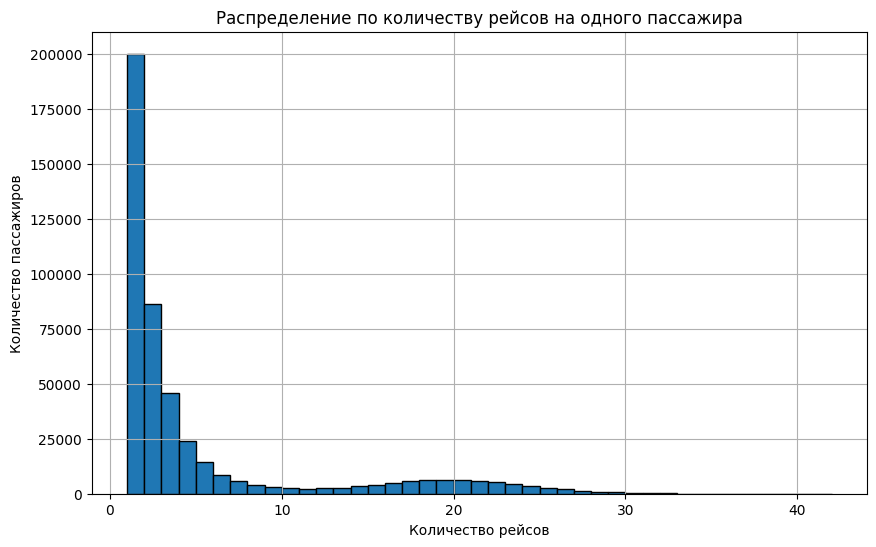

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Заполняем полное имя пассажира на основе первых трёх колонок или Full Name
df_new['Passenger'] = df_new.apply(
    lambda row: row['NickName'] if pd.notna(row['NickName']) else
    f"{row['Last Name']} {row['First Name']} {row['Second Name']}" 
    if pd.notna(row['Last Name']) and pd.notna(row['First Name']) and pd.notna(row['Second Name']) 
    else row['Full Name'], axis=1)

# Считаем количество рейсов для каждого пассажира
flight_counts = df_new.groupby('Passenger').size()

# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(flight_counts, bins=range(1, flight_counts.max() + 1), edgecolor='black')
plt.title('Распределение по количеству рейсов на одного пассажира')
plt.xlabel('Количество рейсов')
plt.ylabel('Количество пассажиров')
plt.grid(True)
plt.show()

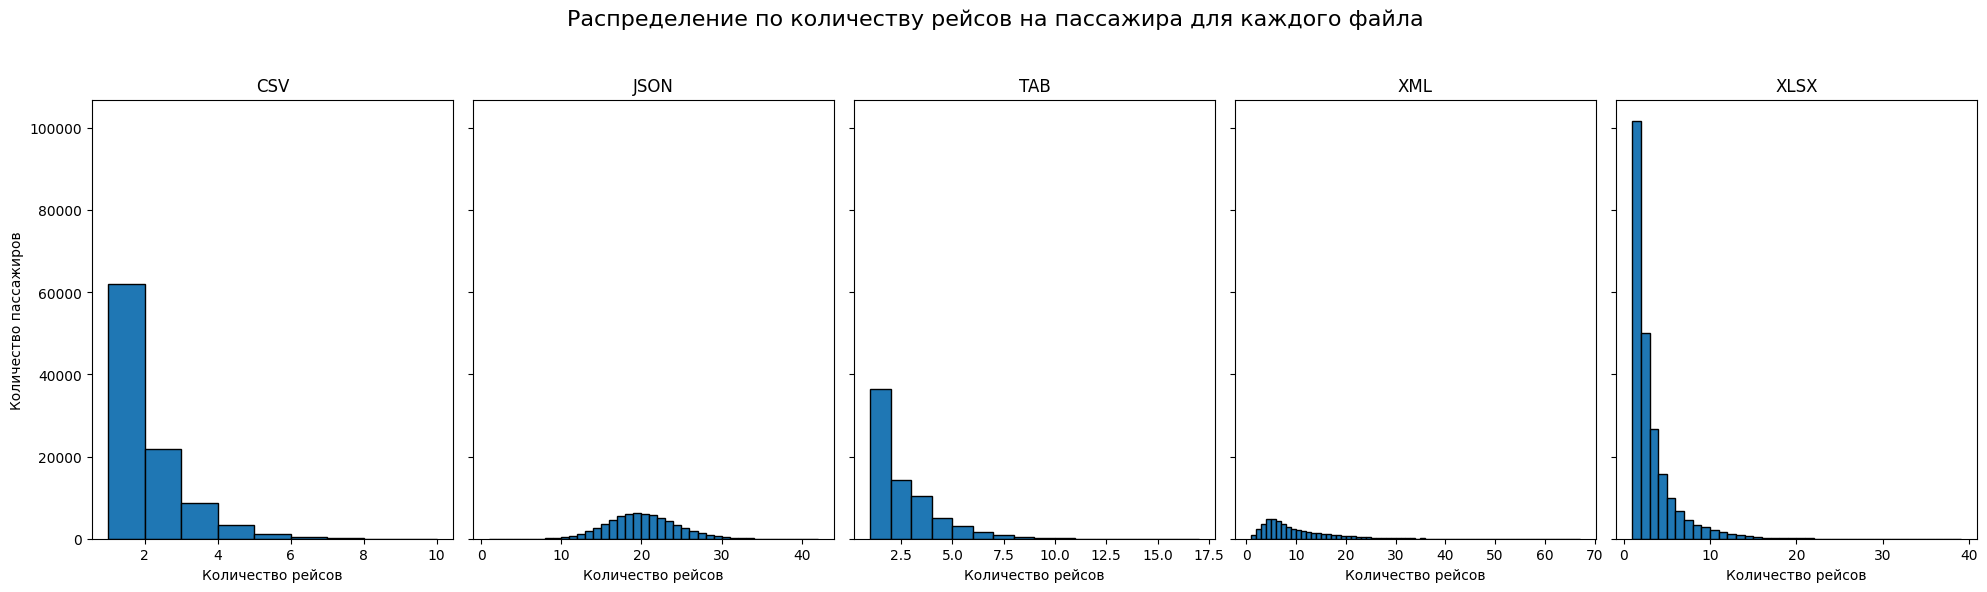

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Путь к итоговому файлу
output_file_path = "./Files_about_flights/results.csv"

# Чтение объединенного датасета
df_combined = pd.read_csv(output_file_path, na_values=["", "N/A", "<NA>", "NaN", "None"], low_memory=False)

# Определение секций по файлам на основе количества строк
split_indices = [155147, 1464134, 1619891, 2055981, 2671752]

# Разделение датасета на секторы
df_file_1 = df_combined.iloc[:split_indices[0]]
df_file_2 = df_combined.iloc[split_indices[0]:split_indices[1]]
df_file_3 = df_combined.iloc[split_indices[1]:split_indices[2]]
df_file_4 = df_combined.iloc[split_indices[2]:split_indices[3]]
df_file_5 = df_combined.iloc[split_indices[3]:split_indices[4]]

# Функция для генерации полного имени пассажира с учетом NickName
def create_passenger_column(df):
    df = df.copy()  # Создаем копию DataFrame, чтобы избежать SettingWithCopyWarning
    df['Passenger'] = df.apply(
        lambda row: row['NickName'] if pd.notna(row['NickName']) else
        f"{row['Last Name']} {row['First Name']} {row['Second Name']}".strip()
        if pd.notna(row['Last Name']) and pd.notna(row['First Name']) and pd.notna(row['Second Name']) 
        else f"{row['Last Name']} {row['First Name']}".strip() 
        if pd.notna(row['Last Name']) and pd.notna(row['First Name'])
        else row['Last Name'] if pd.notna(row['Last Name'])
        else row['First Name'] if pd.notna(row['First Name'])
        else row['Full Name'] if pd.notna(row['Full Name'])
        else 'Unknown', axis=1
    )
    return df

# Применение функции для каждого сектора
df_file_1 = create_passenger_column(df_file_1)
df_file_2 = create_passenger_column(df_file_2)
df_file_3 = create_passenger_column(df_file_3)
df_file_4 = create_passenger_column(df_file_4)
df_file_5 = create_passenger_column(df_file_5)

# Считаем количество рейсов для каждого пассажира
flight_counts_1 = df_file_1.groupby('Passenger').size()
flight_counts_2 = df_file_2.groupby('Passenger').size()
flight_counts_3 = df_file_3.groupby('Passenger').size()
flight_counts_4 = df_file_4.groupby('Passenger').size()
flight_counts_5 = df_file_5.groupby('Passenger').size()

# Построение гистограмм на одном фрейме
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

axes[0].hist(flight_counts_1, bins=range(1, int(flight_counts_1.max()) + 1), edgecolor='black', align='mid')
axes[0].set_title('CSV')
axes[0].set_xlabel('Количество рейсов')
axes[0].set_ylabel('Количество пассажиров')

axes[1].hist(flight_counts_2, bins=range(1, int(flight_counts_2.max()) + 1), edgecolor='black', align='mid')
axes[1].set_title('JSON')
axes[1].set_xlabel('Количество рейсов')

axes[2].hist(flight_counts_3, bins=range(1, int(flight_counts_3.max()) + 1), edgecolor='black', align='mid')
axes[2].set_title('TAB')
axes[2].set_xlabel('Количество рейсов')

max_value_4 = flight_counts_4.max() if not pd.isna(flight_counts_4.max()) else 1
axes[3].hist(flight_counts_4, bins=range(1, int(max_value_4) + 1), edgecolor='black', align='mid')
axes[3].set_title('XML')
axes[3].set_xlabel('Количество рейсов')

max_value_5 = flight_counts_5.max() if not pd.isna(flight_counts_5.max()) else 1
axes[4].hist(flight_counts_5, bins=range(1, int(max_value_5) + 1), edgecolor='black', align='mid')
axes[4].set_title('XLSX')
axes[4].set_xlabel('Количество рейсов')

# Настройка общего заголовка и сетки
fig.suptitle('Распределение по количеству рейсов на пассажира для каждого файла', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Показ графика
plt.show()


In [1]:
import pandas as pd

# Чтение объединенного датасета
df_combined = pd.read_csv('./Files_about_flights/results.csv', na_values=["", "N/A", "<NA>", "NaN", "None"], low_memory=False)

# Определение секций по файлам на основе количества строк
split_indices = [155147, 1464134, 1619891, 2055981, 2671752]

# Разделение датасета на секторы
df_file_1 = df_combined.iloc[:split_indices[0]]
df_file_2 = df_combined.iloc[split_indices[0]:split_indices[1]]
df_file_3 = df_combined.iloc[split_indices[1]:split_indices[2]]
df_file_4 = df_combined.iloc[split_indices[2]:split_indices[3]]
df_file_5 = df_combined.iloc[split_indices[3]:split_indices[4]]

# Функция для создания полного имени пассажира с учетом NickName
def create_passenger_column(df):
    df = df.copy()
    df['Passenger'] = df.apply(
        lambda row: row['NickName'] if pd.notna(row['NickName']) else
        f"{row['Last Name']} {row['First Name']} {row['Second Name']}".strip()
        if pd.notna(row['Last Name']) and pd.notna(row['First Name']) and pd.notna(row['Second Name']) 
        else f"{row['Last Name']} {row['First Name']}".strip() 
        if pd.notna(row['Last Name']) and pd.notna(row['First Name'])
        else row['Last Name'] if pd.notna(row['Last Name'])
        else row['First Name'] if pd.notna(row['First Name'])
        else row['Full Name'] if pd.notna(row['Full Name'])
        else 'Unknown', axis=1
    )
    return df

# Применяем функцию для создания столбца 'Passenger'
df_file_1 = create_passenger_column(df_file_1)
df_file_2 = create_passenger_column(df_file_2)
df_file_3 = create_passenger_column(df_file_3)
df_file_4 = create_passenger_column(df_file_4)
df_file_5 = create_passenger_column(df_file_5)

# Функция для поиска пассажиров с нечетным количеством рейсов и их документов
def find_odd_flight_passengers(df):
    flight_counts = df.groupby('Passenger')['Flight Number'].count()
    odd_flight_passengers = flight_counts[flight_counts % 2 != 0].index
    
    # Получаем DataFrame с пассажирами и их документами
    odd_passenger_info = df[df['Passenger'].isin(odd_flight_passengers)][['Passenger', 'Document']].drop_duplicates()
    
    return odd_passenger_info

# Поиск пассажиров с нечетным количеством рейсов для каждого сектора
odd_passengers_file_1 = find_odd_flight_passengers(df_file_1)
odd_passengers_file_2 = find_odd_flight_passengers(df_file_2)
odd_passengers_file_3 = find_odd_flight_passengers(df_file_3)
odd_passengers_file_4 = find_odd_flight_passengers(df_file_4)
odd_passengers_file_5 = find_odd_flight_passengers(df_file_5)

# Объединение всех секторов в один DataFrame
odd_passengers_combined = pd.concat([
    odd_passengers_file_1, odd_passengers_file_2, 
    odd_passengers_file_3, odd_passengers_file_4, 
    odd_passengers_file_5
])

# Сохранение объединенного DataFrame в CSV файл
output_file_path = './Files_about_flights/odd_flight_passengers.csv'
odd_passengers_combined.to_csv(output_file_path, index=False)

print(f"Данные пассажиров с нечетным количеством рейсов сохранены в {output_file_path}")


Данные пассажиров с нечетным количеством рейсов сохранены в ./Files_about_flights/odd_flight_passengers.csv
